# Problema 3: Comparación de Rendimiento con GLPK/Pyomo
## 1. Modele el problema en Pyomo utilizando el solver GLPK.

In [ ]:
from __future__ import division
from pyomo.environ import *
import time
from pyomo.opt import SolverFactory
import re


Model = ConcreteModel()
# Data de entrada
maxC=10
maxB=8

# Conjuntos
D=RangeSet(1, maxC)
O=RangeSet(1, maxB)

# Parametros
c = {1:5, 2:8, 3:3, 4:7, 5:6, 6:9, 7:4, 8:10, 9:2, 10:11}
b = {1:50, 2:60, 3:55, 4:40, 5:45, 6:70, 7:65, 8:50}

a1= {1:1, 2:2, 3:1, 4:1, 5:0, 6:0, 7:3, 8:1, 9:2, 10:1}
a2= {1:2, 2:1, 3:0, 4:2, 5:1, 6:1, 7:0, 8:3, 9:1, 10:2}
a3= {1:1, 2:1, 3:2, 4:0, 5:2, 6:1, 7:1, 8:0, 9:3, 10:1}
a4= {1:0, 2:2, 3:1, 4:1, 5:1, 6:0, 7:2, 8:1, 9:1, 10:1}
a5= {1:2, 2:0, 3:1, 4:1, 5:1, 6:2, 7:1, 8:1, 9:0, 10:2}
a6= {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1}
a7= {1:0, 2:1, 3:2, 4:1, 5:0, 6:1, 7:2, 8:1, 9:1, 10:0}
a8= {1:1, 2:0, 3:1, 4:2, 5:1, 6:0, 7:1, 8:2, 9:1, 10:1}
a= {1: a1, 2: a2, 3: a3, 4: a4, 5: a5, 6: a6, 7: a7, 8: a8}

# Variable de decisión
Model.x = Var(D, domain=NonNegativeReals)

# función objetivo
Model.obj = Objective(expr=sum(c[i]*Model.x[i] for i in D), sense=maximize)

# Restricciones
# rest. No. 27
Model.rest1 = ConstraintList()
for j in O:
    Model.rest1.add(expr = sum(Model.x[i]*a[j][i] for i in D) <= b[j])

# rest. No. 28
Model.rest2 = ConstraintList()
for i in D:
    Model.rest2.add(expr = Model.x[i] >= 0)
    
# Especificación del solver
start_time = time.time()
solver = SolverFactory('glpk')
response = solver.solve(Model, tee=False, logfile='glpk.log')
end_time = time.time()
execution_time_glpk = end_time - start_time


Model.display()

: 

In [ ]:
# resultados
print("\n### Resumen de la Solución ###")
max_glpk = value(Model.obj)
print("Valor óptimo de la función objetivo:", max_glpk)
print("Componentes seleccionados:")

for i in D:
    if value(Model.x[i]) >= 0.99:  # si es 1
        print("  - Componente {} (costo: {}, valor de x[{}]:{})".format(i, c[i],i, value(Model.x[i])))


## 2. Modelar el problema en Simplex
### Nuevas definiciones del problema
#### Función a maximizar: 
$Z = 5*x_{1}+8*x_{2}+3*x_{3}+7*x_{4}+6*x_{5}+9*x_{6}+4*x_{7}+10*x_{8}+2*x_{9}+11*x_{10}$

#### Restricciones/ Sujeto a :
- $1*x_{1}+2*x_{2}+1*x_{3}+1*x_{4}+0*x_{5}+0*x_{6}+3*x_{7}+1*x_{8}+2*x_{9}+1*x_{10}  \leq 50$
- $2*x_{1}+1*x_{2}+0*x_{3}+2*x_{4}+1*x_{5}+1*x_{6}+0*x_{7}+3*x_{8}+1*x_{9}+2*x_{10}  \leq 60$
- $1*x_{1}+1*x_{2}+2*x_{3}+0*x_{4}+2*x_{5}+1*x_{6}+1*x_{7}+0*x_{8}+3*x_{9}+1*x_{10}  \leq 55$
- $0*x_{1}+2*x_{2}+1*x_{3}+1*x_{4}+1*x_{5}+0*x_{6}+2*x_{7}+1*x_{8}+1*x_{9}+1*x_{10}  \leq 40$
- $2*x_{1}+0*x_{2}+1*x_{3}+1*x_{4}+1*x_{5}+2*x_{6}+1*x_{7}+1*x_{8}+0*x_{9}+2*x_{10}  \leq 45$
- $1*x_{1}+1*x_{2}+1*x_{3}+1*x_{4}+1*x_{5}+1*x_{6}+1*x_{7}+1*x_{8}+1*x_{9}+1*x_{10}  \leq 70$
- $0*x_{1}+1*x_{2}+2*x_{3}+1*x_{4}+0*x_{5}+1*x_{6}+2*x_{7}+1*x_{8}+1*x_{9}+0*x_{10}  \leq 65$
- $1*x_{1}+0*x_{2}+1*x_{3}+2*x_{4}+1*x_{5}+0*x_{6}+1*x_{7}+2*x_{8}+1*x_{9}+1*x_{10}  \leq 50$
- Que todas las $x_{i}$ sean mayores o iguales a 0



### 2.1 Simplex estándar

In [ ]:
from tabulate import tabulate

def mostrarTabla(M, funcion, iteracion, n_var, n_eq):
    headers = (
        [f"x{i+1}" for i in range(n_var)] + [f"s{i+1}" for i in range(n_eq)] + ["b"]
    )
    print("Iteracion #" + str(iteracion))
    print(tabulate(M, headers=headers, tablefmt="fancy_grid"))
    print("Función objetivo:")
    print(tabulate([funcion], headers=headers, tablefmt="fancy_grid"))


def simplexE(f, A, b):
    n_var = len(f)
    n_eq = len(b)

    M = []
    for i in range(n_eq):
        row = A[i] + [0] * n_eq + [b[i]]
        row[n_var + i] = 1
        M.append(row)

    funcion = [-x for x in f] + [0] * n_eq + [0]

    it = 1
    while True:
        index_to_loose = 0
        for j in range(1, len(funcion) - 1):
            if funcion[j] < funcion[index_to_loose]:
                index_to_loose = j

        if funcion[index_to_loose] >= 0:
            break

        index_to_tighten = None
        valueMin = 1e9
        for i in range(n_eq):
            if M[i][index_to_loose] > 0:
                if M[i][-1] / M[i][index_to_loose] < valueMin:
                    valueMin = M[i][-1] / M[i][index_to_loose]
                    index_to_tighten = i

        pivot_val = M[index_to_tighten][index_to_loose]
        M[index_to_tighten] = [x / pivot_val for x in M[index_to_tighten]]

        for i in range(n_eq):
            if i != index_to_tighten:
                ratio = M[i][index_to_loose]
                M[i] = [
                    M[i][j] - ratio * M[index_to_tighten][j] for j in range(len(M[0]))
                ]

        ratio = funcion[index_to_loose]
        funcion = [
            funcion[j] - ratio * M[index_to_tighten][j] for j in range(len(funcion))
        ]

        mostrarTabla(M, funcion, it, n_var, n_eq)
        it += 1

    sol = [0] * n_var
    for j in range(n_var):
        fila_donde_hay_var = -1

        for i in range(n_eq):
            if M[i][j] == 1 and all(M[k][j] == 0 for k in range(n_eq) if k != i):
                fila_donde_hay_var = i
                break

        if fila_donde_hay_var != -1:
            sol[j] = M[fila_donde_hay_var][-1]  # igual a valor libre

    print("Maximo: " + str(funcion[-1]))

    for i in range(n_var):
        print("x[" + str(i + 1) + "] = " + str(sol[i]))
    return it, str(funcion[-1])


# Para el presente programa se considera la ecuación Ax <= b.
# f representa los coeficientes de la funcion a maximizar
# de forma que el producto interno entre f y x, da el valor maximo.

# La implementación está basada en la explicación de simplex presente en
# https://www.youtube.com/watch?v=E72DWgKP_1Y
# por lo que los nombres de variables corresponden a tight/loose en lugar de
# basicas (y no), obedeciendo a nombres representativos frente a la interpretacion
# geometrica conversada en clase.

f = list(c.values())

A = [list(a1.values()), list(a2.values()), list(a3.values()), list(a4.values()), list(a5.values()), list(a6.values()), list(a7.values()), list(a8.values())]

b2 = list(b.values())
start_time1 = time.time()
it, max_simplex = simplexE(f, A, b2)
end_time1 = time.time()
execution_time_simplex = end_time1 - start_time1

### 2.2 Simplex Dual Phase

In [ ]:
import numpy as np
import pandas as pd
def show_table(table: pd.DataFrame, title: str = ""):
    from tabulate import tabulate
    
    if title:
        print(f"=== {title} ===")
    print(tabulate(table, headers="keys", tablefmt="psql", showindex=True))
    print()  # Separación final

# Definición de la matriz de restricciones y lado derecho.
# Orden de columnas: las primeras 10 corresponden a las variables originales (x1 a x10),
# las siguientes 8 a las variables de holgura (s1 a s8) y finalmente el lado derecho 'ld'.
restricciones = np.array([
    # x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, s1, s2, s3, s4, s5, s6, s7, s8, ld
    [ 1, 2, 1, 1, 0, 0, 3, 1, 2,  1,   1, 0, 0, 0, 0, 0, 0, 0, 50 ],  # Restricción 1 (≤ 50)
    [ 2, 1, 0, 2, 1, 1, 0, 3, 1,  2,   0, 1, 0, 0, 0, 0, 0, 0, 60 ],  # Restricción 2 (≤ 60)
    [ 1, 1, 2, 0, 2, 1, 1, 0, 3,  1,   0, 0, 1, 0, 0, 0, 0, 0, 55 ],  # Restricción 3 (≤ 55)
    [ 0, 2, 1, 1, 1, 0, 2, 1, 1,  1,   0, 0, 0, 1, 0, 0, 0, 0, 40 ],  # Restricción 4 (≤ 40)
    [ 2, 0, 1, 1, 1, 2, 1, 1, 0,  2,   0, 0, 0, 0, 1, 0, 0, 0, 45 ],  # Restricción 5 (≤ 45)
    [ 1, 1, 1, 1, 1, 1, 1, 1, 1,  1,   0, 0, 0, 0, 0, 1, 0, 0, 70 ],  # Restricción 6 (≤ 70)
    [ 0, 1, 2, 1, 0, 1, 2, 1, 1,  0,   0, 0, 0, 0, 0, 0, 1, 0, 65 ],  # Restricción 7 (≤ 65)
    [ 1, 0, 1, 2, 1, 0, 1, 2, 1,  1,   0, 0, 0, 0, 0, 0, 0, 1, 50 ]   # Restricción 8 (≤ 50)
])

# Nombres de columnas (variables originales, de holgura y lado derecho)
columnas = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10',
            's1','s2','s3','s4','s5','s6','s7','s8','ld']

# Variables básicas iniciales: las variables de holgura
base = ['s1','s2','s3','s4','s5','s6','s7','s8']

# Coeficientes de la función objetivo
# Función a maximizar: 
#     Z = 5*x1 + 8*x2 + 3*x3 + 7*x4 + 6*x5 + 9*x6 + 4*x7 + 10*x8 + 2*x9 + 11*x10
# En la tabla simplex se coloca la fila Z con los coeficientes multiplicados por (-1).
coeficientes_z = {
    'x1': 5, 'x2': 8, 'x3': 3, 'x4': 7, 'x5': 6,
    'x6': 9, 'x7': 4, 'x8': 10, 'x9': 2, 'x10': 11,
    's1': 0, 's2': 0, 's3': 0, 's4': 0, 's5': 0, 's6': 0, 's7': 0, 's8': 0,
    'ld': 0
}

# Armado de la tabla inicial utilizando pandas
tabla_inicial = pd.DataFrame(restricciones, columns=columnas, index=base)

# Agregar la fila de la función objetivo Z
fila_z = [ coeficientes_z[var] for var in columnas ]
tabla_inicial.loc['Z'] = fila_z

print("Tabla inicial (Simplex - Función a Maximizar):")
show_table(tabla_inicial)


def calcular_costos_reducidos(tabla: pd.DataFrame, base: list, coeficientes_z: dict):

    # Partimos de -c_j (para cada columna j)
    z = np.array([-coeficientes_z[var] for var in tabla.columns], dtype=np.float64)

    # Sumamos c[b] * fila(b) para cada variable base b
    for b in base:
        z += coeficientes_z[b] * tabla.loc[b].values

    # Asignamos la nueva fila Z a la tabla
    tabla.loc['Z'] = z
    return tabla

def verificar_optimalidad(tabla):
    # Verificar si todos los costos reducidos son no negativos
    return all(tabla.loc['Z'][:-1] >= 0)  # Exepto el lado derecho

def seleccionar_var_entrada(tabla, base):
    z_values = tabla.loc['Z'][:-1]  # Excluyendo el lado derecho
    z_values = z_values.drop(labels=base, errors='ignore')  # ← evitar repetir variables de la base
    indice_mas_neg = np.argmin(z_values)  # Posicion del costo reducido más negativo
    valor = z_values.iloc[indice_mas_neg]  # Valor del costo reducido más negativo

    if valor >= 0:
        return None
    var_entrada = z_values.index[indice_mas_neg]
    print(f"Variable de entrada: {var_entrada} (costo reducido = {valor:.4f})")
    return var_entrada

def calcular_razones(tabla, var_entrada):
    # Calcular las razones para determinar la variable de salida
    razones = []
    filas_basicas = tabla.index[:-1]  # Excluyendo la fila Z
    for fila in filas_basicas:
        coef = tabla.loc[fila, var_entrada]
        ld = tabla.loc[fila, 'ld']
        if coef > 0:
            razon = ld / coef
            razones.append(razon)
        else:
            razones.append( np.inf)
    idx_var_salida = np.argmin(razones)
    var_salida = filas_basicas[idx_var_salida]
    print(f"Variable de salida: {var_salida} (razón mínima = {razones[idx_var_salida]:.4f})")
    return var_salida


def pivoteo(tabla, var_entrada, var_salida):
    nueva_tabla = tabla.copy()
    print(f"\nPivoteo: {var_entrada} entra, {var_salida} sale")
    pivote = nueva_tabla.loc[var_salida, var_entrada]  # Elemento pivote
    print(f"Elemento pivote: {pivote}")
    nueva_tabla.loc[var_salida] = nueva_tabla.loc[var_salida] / pivote  

    # volver 0 los demás elementos de la columna de la variable de entrada
    for fila in nueva_tabla.index:
        if fila != var_salida:
            coef = nueva_tabla.loc[fila, var_entrada]
            nueva_tabla.loc[fila] = nueva_tabla.loc[fila] - coef * nueva_tabla.loc[var_salida]
    
    # Actualizar la variable básica
    
    nueva_base =  []
    for fila in nueva_tabla.index[:-1]:
        if fila == var_salida:
            nueva_base.append(var_entrada)  # Cambiar la variable básica , reemplazar la variable que sale por la que entra
        else:
            nueva_base.append(fila) # Mantener la variable básica
    nueva_tabla.index = nueva_base + ['Z']  # Actualizar el índice de la tabla
    return nueva_tabla, nueva_base  

def simplex(tabla, base, coeficientes_z):
    iteracion = 0

    while True:
        print(f"\n Iteración {iteracion}")
        tabla = calcular_costos_reducidos(tabla, base,coeficientes_z)  # Calcular costos reducidos

        print("Costos reducidos:")
        show_table(tabla) 

        if verificar_optimalidad(tabla):
            print("\n Solución óptima alcanzada (Fase 1 terminada).")
            break

        var_entrada = seleccionar_var_entrada(tabla, base)  # Seleccionar variable de entrada

        if var_entrada is None:
            print("No hay variable de entrada. Ha terminado el algoritmo.")
            break

        var_salida = calcular_razones(tabla, var_entrada)

        tabla, base = pivoteo(tabla, var_entrada, var_salida)  # Pivoteo actualiza tabla y base

        print(" Tabla después del pivoteo:")
        show_table(tabla) 
        iteracion += 1

    return tabla, base, iteracion
start_time2 = time.time()

tabla_inicial= tabla_inicial.astype(float)  
tabla_final, base_final, it_dual = simplex(tabla_inicial.copy(), base.copy(), coeficientes_z)
end_time2 = time.time()
execution_time_simplex_dual = end_time2 - start_time2

## PARA IMPRIMIR

# Mostrar la tabla final obtenida tras la ejecución del algoritmo simplex
print("\nTabla final (Solución Óptima):")
show_table(tabla_final, title="Tabla Final Simplex")

# Extraer la solución óptima para las variables originales (x1 a x10)
solucion = {}
for var in ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']:
    # Si la variable está en la base, su valor es el del lado derecho (ld) de la fila correspondiente;
    # de lo contrario, al ser no básica, su valor es 0.
    if var in base_final:
        solucion[var] = tabla_final.loc[var, 'ld']
    else:
        solucion[var] = 0

# Imprimir la solución óptima
print("Solución óptima de las variables:")
for var, valor in solucion.items():
    print(f"  {var} = {valor}")

# Mostrar el valor óptimo de la función objetivo (se encuentra en la fila 'Z' en la columna 'ld')
max_simplex_dual = tabla_final.loc['Z', 'ld']
print("\nValor óptimo de la función objetivo:", max_simplex_dual)


## 3. Comparar resultados

In [ ]:
print ("Tiempo GLPK:", execution_time_glpk)
print ("Tiempo Simplex Estándar:", execution_time_simplex)
print ("Tiempo Simplex Dual:", execution_time_simplex_dual)

print ("Menor tiempo:", min(execution_time_glpk, execution_time_simplex, execution_time_simplex_dual))
print ("Mayor tiempo:", max(execution_time_glpk, execution_time_simplex, execution_time_simplex_dual))
print ("Tiempo promedio:", (execution_time_glpk + execution_time_simplex + execution_time_simplex_dual)/3)
print ("------------------------------------------------------------------------------------------")


iter_GLPK = None
with open('glpk.log', 'r') as f:
    for line in f:
        m = re.match(r'^\*\s+(\d+):', line)
        if m:
            iter_GLPK = int(m.group(1))

print("Iteraciones GLPK:", iter_GLPK)
print ("Iteraciones Simplex Estándar:", it)
print ("Iteraciones Simplex Dual:", it_dual)
print ("-------------------------------------------------------------------------------------------")
print ("Optimizacion con GLPK:", max_glpk)
print ("Optimizacion con Simplex Estándar:", max_simplex)
print ("Optimizacion con Simplex Dual:", max_simplex_dual)




## 4. Análisis de diferencias en rendimiento y precisión

| Implementación                | Tiempo (s)    | Iteraciones | Valor óptimo (Z)        |
|:------------------------------|:-------------:|:-----------:|:------------------------|
| **GLPK**| 0.06234       | 4           | 375.625                  |
| **Simplex Estándar** | 0.00747  | 5           | 375.625                  |
| **Simplex Dual**| 0.05385       | 4           | 375.62500000000006       |

### Rendimiento
Con respecto a la velocidad de ejecución, se descubrió que el algoritmo más rápido fue el Simplex Estándar (0.00747 s), casi 8.3× más veloz que GLPK (0.06234 s). El más lento fue el GLPK, debido principalmente al overhead de llamadas externas. El Simplex Dual fue el resultado intermedio (0.05385 s), solo un 14 % más rápido que GLPK. Por otro lado, con respecto al numero de iteraciones, GLPK y Simplex Dual convergen en 4 iteraciones. Simplex Estándar necesita 5 iteraciones, un 25 % más que GLPK; sin embargo, su tiempo es notablemente menor.

### Precisión
Se notó que hay consistencia en los resultados. Todas las implementaciones alcanzan el mismo óptimo **Z = 375.625** (la pequeña diferencia en Simplex Dual es < 10⁻¹³). No hay desviaciones numéricas significativas entre los resultados del solver profesional y el código propio. La mínima discrepancia se debe a redondeos del float en Python, irrelevante a nivel práctico.

### Conclusión
Se podría afirmar que el algoritmo más eficiente es el Simplex Estándar, pues en compraración con el GLPK no solo alcanza el mismo resultado, pero lo supera en rendimiento. Así que, en escenarios académicos como este mismo, o de prototipado rápido, el código propio ofrece una solución ágil y exacta. Sin embargo, se cree que para instancias más grandes, un solver profesional como GLPK sigue siendo la opción más fiable y escalable. 

## 5. Investigue y discuta qué técnicas de optimización para GLPK para optimizar rendimiento

La razón principal por la demora del GLPK es el overhead asociado a cómo Pyomo invoca a GLPK. Esto sucede de la siguiente forma:

1. Inicio de un proceso externo
   Cada vez que se llama a glpsol, el sistema operativo debe arrancar un nuevo proceso, cargar el ejecutable de GLPK en memoria y luego destruirlo al terminar. Ese “arranque y parada” suele sumar decenas de milisegundos en cada llamada.

2. Escritura/lectura de archivos temporales
   Pyomo primero vuelca el modelo a un fichero .lp (o .nl), luego GLPK escribe sus salidas (.raw, .wglp, etc.), y finalmente Pyomo vuelve a leerlos para extraer la solución. Todo ese I/O en disco es mucho más lento que operar directamente en memoria.

En conjunto, ese tiempo de gestión de procesos e I/O eclipsa el tiempo puro de cómputo del algoritmo simplex en C, por eso GLPK se demora más comparado con una implementación que trabaje todo en memoria o con menor overhead. Estas son dos posibles soluciones qu eayudan a reducir el tiempo de overhead:

1. Usar I/O en memoria (`solver_io='nl'`)
   - En lugar de escribir el modelo a disco, Pyomo envía directamente el problema en formato NL a GLPK mediante un pipe en memoria.  
   - Ejemplo en Pyomo:
     ```python
     solver = SolverFactory('glpk', solver_io='nl')
     results = solver.solve(model, tee=False)
     ```
   - Evita la creación y parseo de archivos `.lp`, reduciendo drásticamente el tiempo de escritura/lectura.

2. Invocar GLPK como biblioteca (API C)
   - Utilizar bindings como SWIGLPK o pyglpk para llamar directamente a las funciones de GLPK desde Python, sin pasar por el ejecutable externo.  
   - Ejemplo mínimo con `swiglpk`:
     ```python
     from swiglpk import glp_read_lp, glp_simplex, glp_get_obj_val, GLP_MSG_OFF
     lp = glp_read_lp('modelo.lp', None)
     glp_simplex(lp, None)
     z_opt = glp_get_obj_val(lp)
     ```
   - Al eliminar el proceso `glpsol` y su E/S de archivos, se minimiza el overhead de proceso y disco, dejando solo el tiempo de cómputo interno de GLPK.

## 6. Graficas comparativas para distintos tamaños de problema






Tiempos de ejecución (s):
GLPK: [0.16227054595947266, 0.12110590934753418, 0.13332605361938477, 0.13883304595947266, 0.15958666801452637, 0.16813278198242188, 0.19837093353271484, 0.2659633159637451, 0.28272271156311035, 0.41707539558410645]
Promedio GLPK: 0.20473873615264893
Simplex Estándar: [0.0, 0.002005338668823242, 0.029735326766967773, 0.08332562446594238, 0.22031140327453613, 0.34708094596862793, 0.7665362358093262, 0.8861382007598877, 3.0043447017669678, 6.763003349304199]
Promedio Simplex Estándar: 1.2102481126785278
Simplex Dual: [0.0, 0.0, 0.015004158020019531, 0.046694278717041016, 0.058120012283325195, 0.09181427955627441, 0.10156607627868652, 0.3858072757720947, 0.6410267353057861, 0.5099256038665771]
Promedio Simplex Dual: 0.18499584197998048
-------------------------------------------------------------------------------------------
Iteraciones:
GLPK: [5, 12, 33, 44, 66, 73, 90, 111, 111, 151]
Promedio GLPK: 69.6
Simplex Estándar: [7, 23, 57, 67, 116, 158, 188, 187, 435

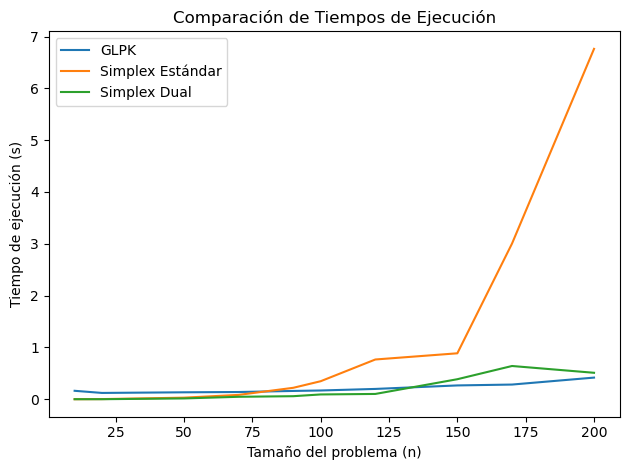

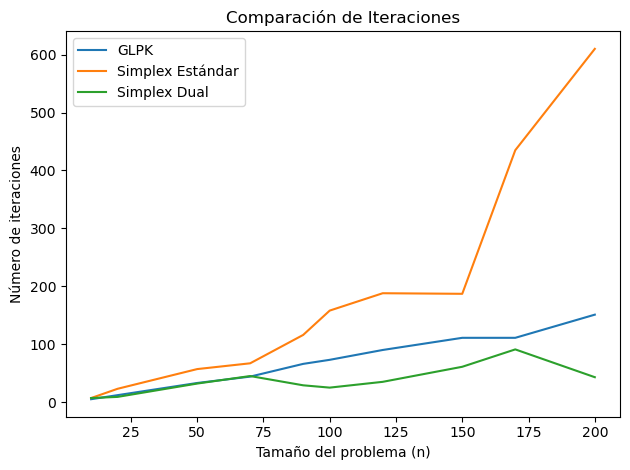

In [1]:
import matplotlib.pyplot as plt
import time
import re
import numpy as np
from pyomo.environ import ConcreteModel, RangeSet, Var, NonNegativeReals, Objective, maximize, ConstraintList, SolverFactory


def simplexSinPrints(f, A, b):
    n_var = len(f)
    n_eq = len(b)

    M = []
    for i in range(n_eq):
        row = A[i] + [0] * n_eq + [b[i]]
        row[n_var + i] = 1
        M.append(row)

    funcion = [-x for x in f] + [0] * n_eq + [0]

    it = 1
    while True:
        index_to_loose = 0
        for j in range(1, len(funcion) - 1):
            if funcion[j] < funcion[index_to_loose]:
                index_to_loose = j

        if funcion[index_to_loose] >= 0:
            break

        index_to_tighten = None
        valueMin = 1e9
        for i in range(n_eq):
            if M[i][index_to_loose] > 0:
                if M[i][-1] / M[i][index_to_loose] < valueMin:
                    valueMin = M[i][-1] / M[i][index_to_loose]
                    index_to_tighten = i

        pivot_val = M[index_to_tighten][index_to_loose]
        M[index_to_tighten] = [x / pivot_val for x in M[index_to_tighten]]

        for i in range(n_eq):
            if i != index_to_tighten:
                ratio = M[i][index_to_loose]
                M[i] = [
                    M[i][j] - ratio * M[index_to_tighten][j] for j in range(len(M[0]))
                ]

        ratio = funcion[index_to_loose]
        funcion = [
            funcion[j] - ratio * M[index_to_tighten][j] for j in range(len(funcion))
        ]

        it += 1

    sol = [0] * n_var
    for j in range(n_var):
        fila_donde_hay_var = -1

        for i in range(n_eq):
            if M[i][j] == 1 and all(M[k][j] == 0 for k in range(n_eq) if k != i):
                fila_donde_hay_var = i
                break

        if fila_donde_hay_var != -1:
            sol[j] = M[fila_donde_hay_var][-1]  # igual a valor libre

    return it, str(funcion[-1])

# Definimos los tamaños de problema que queremos probar
problem_sizes = [10, 20, 50, 70, 90, 100, 120, 150, 170, 200]

times_glpk=[] 
iters_glpk=[]
times_simplex= [] 
iters_simplex=[] 
times_dual=[]
iters_dual = []

for n in problem_sizes:
    
    # 1) Generación de datos aleatorios de tamaño n
    m = n  # cant rest igual a cant var
    c = {i: np.random.uniform(1, 10) for i in range(1, n+1)}
    A = {j: {i: np.random.uniform(0, 5) for i in range(1, n+1)} for j in range(1, m+1)}
    b = {j: sum(A[j].values()) * 0.5 for j in range(1, m+1)}

    # 2) Construcción del modelo Pyomo
    Model = ConcreteModel()
    Model.D = RangeSet(1, n)
    Model.O = RangeSet(1, m)
    Model.x = Var(Model.D, domain=NonNegativeReals)
    Model.obj = Objective(expr=sum(c[i]*Model.x[i] for i in Model.D), sense=maximize)
    Model.rest = ConstraintList()
    for j in Model.O:
        Model.rest.add(expr=sum(Model.x[i]*A[j][i] for i in Model.D) <= b[j])

    start = time.time()
    solver = SolverFactory('glpk')
    log_file = f'glpk_{n}.log'
    result = solver.solve(Model, tee=False, logfile=log_file)
    elapsed_glpk = time.time() - start

    iter_count = None
    with open(log_file) as f:
        for line in f:
            m_iter = re.match(r'^\*\s+(\d+):', line)
            if m_iter:
                iter_count = int(m_iter.group(1))

    times_glpk.append(elapsed_glpk)
    iters_glpk.append(iter_count)
    
    # 3) Ejecución del algoritmo Simplex Estándar
    f_list   = list(c[i] for i in range(1, n+1))
    A_list   = list(
        list(A[j][i] for i in range(1, n+1))
        for j in range(1, m+1))
    b_list   = list(b[j] for j in range(1, m+1))
    
    start_time1 = time.time()
    it_std, z_std = simplexSinPrints(f_list, A_list, b_list)
    end_time1 = time.time()
    elapsed_simplex = end_time1 - start_time1
    times_simplex.append(elapsed_simplex)
    iters_simplex.append(it_std)
    
    # 4) Ejecución del algoritmo Simplex Dual
    A_dual = list(map(list, zip(*A_list))) 
    start_time2 = time.time()
    it_dual, z_dual = simplexSinPrints(b_list, A_dual, f_list)
    end_time2 = time.time()
    elapsed_simplex_dual = end_time2 - start_time2
    times_dual.append(elapsed_simplex_dual)
    iters_dual.append(it_dual)

print ("Tiempos de ejecución (s):")
print ("GLPK:", times_glpk)
print ("Promedio GLPK:", np.mean(times_glpk))
print ("Simplex Estándar:", times_simplex) 
print ("Promedio Simplex Estándar:", np.mean(times_simplex))
print ("Simplex Dual:", times_dual)
print ("Promedio Simplex Dual:", np.mean(times_dual))
print ("-------------------------------------------------------------------------------------------")
print ("Iteraciones:")
print ("GLPK:", iters_glpk)
print ("Promedio GLPK:", np.mean(iters_glpk))
print ("Simplex Estándar:", iters_simplex)
print ("Promedio Simplex Estándar:", np.mean(iters_simplex))
print ("Simplex Dual:", iters_dual)
print ("Promedio Simplex Dual:", np.mean(iters_dual))
print ("-------------------------------------------------------------------------------------------")

# graph 1: Tiempo de ejecución vs Tamaño del problema
plt.figure()
plt.plot(problem_sizes, times_glpk, label='GLPK')
plt.plot(problem_sizes, times_simplex, label='Simplex Estándar')
plt.plot(problem_sizes, times_dual, label='Simplex Dual')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Comparación de Tiempos de Ejecución')
plt.legend()
plt.tight_layout()
plt.show()

# graph 2: Iteraciones vs Tamaño del problema
plt.figure()
plt.plot(problem_sizes, iters_glpk, label='GLPK')
plt.plot(problem_sizes, iters_simplex, label='Simplex Estándar')
plt.plot(problem_sizes, iters_dual, label='Simplex Dual')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Número de iteraciones')
plt.title('Comparación de Iteraciones')
plt.legend()
plt.tight_layout()
plt.show()


Observando los datos de n = [10, 20, 50, 70, 90, 100, 120, 150, 170, 200], vemos que en instancias pequeñas (n ≤ 50) los tres métodos resuelven prácticamente en cero segundos y con muy pocas iteraciones. Sin embargo, al llegar a n = 200 la implementación de **Simplex Estándar** explota en tiempo (hasta 6.76 s) y en número de pivoteos (610), muy por encima de **GLPK** (0.42 s, 151 iteraciones) y de **Simplex Dual** (0.51 s, 43 iteraciones). De hecho, el Dual alcanza el menor promedio de tiempo (0.185 s) y de iteraciones (37.7), mientras que GLPK promedia 0.205 s y 69.6 iteraciones, y el Standard ronda 1.21 s con 184.8 pivoteos. En consecuencia, para problemas de tamaño medio a grande resulta claro que el **Simplex Dual** ofrece el mejor compromiso entre velocidad y número de iteraciones, reservando el uso de GLPK cuando se prefiera la fiabilidad de un solver profesional y evitando la versión Estándar propia en escenarios de mayor escala.  
